In [15]:

import os
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score , confusion_matrix
import cv2
import random
import seaborn as sns
from imgaug import augmenters as iaa
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


## First approach

In [4]:
import matplotlib.pyplot as plt
import cv2 
import os

# Dataset directory and classes
dataset_dir = "/kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset"
classes = ["Chickenpox", "Measles", "Monkeypox", "Normal"]

# Load image paths for each class
image_paths = {cls: [os.path.join(dataset_dir, cls, img) for img in os.listdir(os.path.join(dataset_dir, cls))] for cls in classes}

# Load and convert images to grayscale
image_data = {}
for cls in classes:
    image_data[cls] = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths[cls]]


In [5]:
for cls in classes:
    if image_data[cls]:  # Ensure there are images
        print(f"Class: {cls}, First Image Shape: {image_data[cls][0].shape}")


Class: Chickenpox, First Image Shape: (224, 224)
Class: Measles, First Image Shape: (224, 224)
Class: Monkeypox, First Image Shape: (224, 224)
Class: Normal, First Image Shape: (224, 224)


In [7]:
def compute_glcm_features(image, distances, angles):


    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    features = {
        "ASM": graycoprops(glcm, "ASM").mean(),
        "Contrast": graycoprops(glcm, "contrast").mean(),
        "Correlation": graycoprops(glcm, "correlation").mean(),
        "Homogeneity": graycoprops(glcm, "homogeneity").mean(),
        "Energy": np.sqrt(graycoprops(glcm, "ASM")).mean(),
    }
    
    return features

def extract_glcm_features_from_dataset(dataset_dir, classes, distances, angles):

    features_dict = {cls: [] for cls in classes}  # Dictionary to store features for each class

    for cls in classes:
        cls_dir = os.path.join(dataset_dir, cls)

        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            features = compute_glcm_features(image, distances, angles)
            
            
            features_dict[cls].append(features)
    
    return features_dict

In [ ]:
def save_glcm_features_to_dataframe(features_dict, dataset_dir, classes):
   
    # Prepare a list to hold all the rows of data for the DataFrame
    data = []

    # Iterate over each class
    for cls in classes:
        cls_dir = os.path.join(dataset_dir, cls)
        
        # Iterate through all images in the class folder
        for img_name, features in zip(os.listdir(cls_dir), features_dict[cls]):
            # Include the image filename and its class in the feature dictionary
            row = {"Image Name": img_name, "Class": cls}
            row.update(features)  # Add the GLCM features to the row
            data.append(row)
    
    # Create a DataFrame from the list of rows
    df = pd.DataFrame(data)

    # Save the DataFrame to a writable location (e.g., /kaggle/working/)
    df.to_csv('/kaggle/working/glcm_features.csv', index=False)

    return df



In [8]:

 
distances = [1, 2] 
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles in radians


glcm_features = extract_glcm_features_from_dataset(dataset_dir, classes, distances, angles)

    

In [10]:
def fisher_score(features, labels):
  
    unique_classes = np.unique(labels)
    mean_total = np.mean(features, axis=0)
    scores = np.zeros(features.shape[1])

    for feature_idx in range(features.shape[1]):
        numerator = 0
        denominator = 0

        for cls in unique_classes:
            cls_mask = labels == cls
            cls_features = features[cls_mask, feature_idx]
            cls_mean = np.mean(cls_features)
            cls_var = np.var(cls_features)

            numerator += len(cls_features) * (cls_mean - mean_total[feature_idx]) ** 2
            denominator += len(cls_features) * cls_var

        scores[feature_idx] = numerator / (denominator + 1e-10)  # Add small value to avoid division by zero

    return scores

def prepare_features_for_fisher(glcm_features, classes):
  
    features_list = []
    labels_list = []
    
    for cls in classes:
        cls_features = glcm_features[cls]
        

        df = pd.DataFrame(cls_features)
        
        features_list.append(df.values)
        labels_list.extend([cls] * len(cls_features))

    feature_array = np.vstack(features_list)
    label_encoder = LabelEncoder()
    label_array = label_encoder.fit_transform(labels_list)

    return feature_array, label_array, label_encoder

In [13]:
feature_array, label_array, label_encoder = prepare_features_for_fisher(glcm_features, classes)
fisher_scores = fisher_score(feature_array, label_array)
sorted_indices = np.argsort(fisher_scores)[::-1]
print("Features ranked by Fisher Score:")
for idx in sorted_indices:
    print(f"Feature {idx}: Fisher Score = {fisher_scores[idx]}")
    
top_k = 5
selected_features = feature_array[:, sorted_indices[:top_k]]
print(f"Selected top-{top_k} features:")
print(selected_features)

Features ranked by Fisher Score:
Feature 3: Fisher Score = 0.42064691569344154
Feature 4: Fisher Score = 0.16814370609352292
Feature 0: Fisher Score = 0.07252556136770937
Feature 2: Fisher Score = 0.0377437551481616
Feature 1: Fisher Score = 0.03677102277697559
Selected top-5 features:
[[5.94988004e-01 3.39439378e-01 1.15232194e-01 9.72504747e-01
  2.80007290e+02]
 [2.55851227e-01 2.02884155e-02 4.18097010e-04 9.78396617e-01
  1.28927734e+02]
 [5.93979074e-01 7.26133005e-02 5.33495129e-03 9.60834869e-01
  4.65575672e+01]
 ...
 [4.07055340e-01 8.05688565e-02 6.51104735e-03 9.37174057e-01
  2.03876768e+02]
 [3.30931441e-01 4.42962021e-02 1.96887451e-03 9.17594793e-01
  9.93745350e+01]
 [2.88252839e-01 3.40054603e-02 1.16761979e-03 9.77880930e-01
  9.75702457e+01]]


In [14]:
def apply_smote(features, labels, random_state=42):

    smote = SMOTE(random_state=random_state)
    features_resampled, labels_resampled = smote.fit_resample(features, labels)
    return features_resampled, labels_resampled

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

def train_svm_with_polynomial_kernel(features, labels, degree=3, test_size=0.2, random_state=42):

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state
    )

    # Initialize and train the SVM classifier
    svm_model = SVC(kernel="poly", degree=degree, random_state=random_state)
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return svm_model, accuracy


polynomial_degree = 3

    # Train the SVM with a polynomial kernel and evaluate it
svm_model, accuracy = train_svm_with_polynomial_kernel(
        selected_features, label_array, degree=polynomial_degree)

print(f"Trained SVM model with polynomial kernel (degree {polynomial_degree}) achieved an accuracy of {accuracy * 100:.2f}%.")


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        65
           3       0.33      1.00      0.50        51

    accuracy                           0.33       154
   macro avg       0.08      0.25      0.12       154
weighted avg       0.11      0.33      0.16       154

Accuracy: 33.12%
Trained SVM model with polynomial kernel (degree 3) achieved an accuracy of 33.12%.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
import numpy as np
import cv2
import os

def compute_first_order_features(image):
    """
    Compute first-order statistical features from the histogram of an image.

    Parameters:
    - image: 2D grayscale numpy array.

    Returns:
    - features: Dictionary containing first-order statistical features.
    """
    # Flatten the image to 1D
    pixel_values = image.flatten()
    
    # Compute the histogram
    histogram, bin_edges = np.histogram(pixel_values, bins=256, range=(0, 256), density=False)
    
    # Normalize the histogram to get P(I)
    total_pixels = pixel_values.size
    p_i = histogram / total_pixels  # Probability of each gray level (P(I))
    
    # Compute mean (m1)
    gray_levels = np.arange(256)  # Gray levels 0 to 255
    mean = np.sum(gray_levels * p_i)
    
    # Compute variance (μ2)
    variance = np.sum(((gray_levels - mean) ** 2) * p_i)
    
    # Compute skewness (μ3)
    skewness = np.sum(((gray_levels - mean) ** 3) * p_i)
    
    # Compute kurtosis (μ4)
    kurtosis = np.sum(((gray_levels - mean) ** 4) * p_i)
    
    # Return features as a dictionary
    features = {
        "Mean": mean,
        "Variance": variance,
        "Skewness": skewness,
        "Kurtosis": kurtosis
    }
    return features

def extract_first_order_features_from_dataset(dataset_dir, classes):

    features_dict = {cls: [] for cls in classes}  # Dictionary to store features for each class

    # Iterate over each class in the dataset
    for cls in classes:
        cls_dir = os.path.join(dataset_dir, cls)
        
        # Iterate through all images in the class folder
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            
            # Read and convert the image to grayscale
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Skip invalid or empty images
            if image is None:
                continue
            
            # Compute first-order statistical features
            features = compute_first_order_features(image)
            
            # Store features for the current image
            features_dict[cls].append(features)
    
    return features_dict

first_order_features = extract_first_order_features_from_dataset(dataset_dir, classes)
    
print("First-Order Statistical Features for Chickenpox class:")
for features in first_order_features["Chickenpox"]:
    print(features)


First-Order Statistical Features for Chickenpox class:
{'Mean': 164.86615114795921, 'Variance': 5063.141284102154, 'Skewness': -450329.7302114026, 'Kurtosis': 73236698.57620463}
{'Mean': 150.76807637117346, 'Variance': 2985.156929702076, 'Skewness': -67188.32640086062, 'Kurtosis': 17948082.350586742}
{'Mean': 192.6753826530612, 'Variance': 594.8483863331685, 'Skewness': -19539.94411828472, 'Kurtosis': 1954679.3109063283}
{'Mean': 121.38460618622449, 'Variance': 2238.226400466722, 'Skewness': 16995.088491992137, 'Kurtosis': 9184646.13582006}
{'Mean': 138.71287069515307, 'Variance': 3713.277669166635, 'Skewness': 24171.89427014449, 'Kurtosis': 30112383.184604723}
{'Mean': 157.89566725127548, 'Variance': 789.5643897094313, 'Skewness': -9858.892922412055, 'Kurtosis': 1539709.1725605973}
{'Mean': 158.12097417091837, 'Variance': 365.48907220150124, 'Skewness': -5744.8815536854745, 'Kurtosis': 546685.7658370065}
{'Mean': 157.6568678252551, 'Variance': 1385.5316743731546, 'Skewness': -17000.80

In [21]:
def save_first_order_features_to_dataframe(features_dict, dataset_dir, classes):
  
    
    data = []

    # Iterate over each class
    for cls in classes:
        cls_dir = os.path.join(dataset_dir, cls)

        for img_name, features in zip(os.listdir(cls_dir), features_dict[cls]):
            # Include the image filename and its class in the feature dictionary
            row = {"Image Name": img_name, "Class": cls}
            row.update(features)  # Add the first-order features to the row
            data.append(row)
    
    df = pd.DataFrame(data)
    df.to_csv('/kaggle/working/first_order_features.csv', index=False)

    return df


df = save_first_order_features_to_dataframe(first_order_features, dataset_dir, classes)

print(df.head())


         Image Name       Class        Mean     Variance       Skewness  \
0  chickenpox53.png  Chickenpox  164.866151  5063.141284 -450329.730211   
1  chickenpox56.png  Chickenpox  150.768076  2985.156930  -67188.326401   
2  chickenpox40.png  Chickenpox  192.675383   594.848386  -19539.944118   
3  chickenpox96.png  Chickenpox  121.384606  2238.226400   16995.088492   
4  chickenpox59.png  Chickenpox  138.712871  3713.277669   24171.894270   

       Kurtosis  
0  7.323670e+07  
1  1.794808e+07  
2  1.954679e+06  
3  9.184646e+06  
4  3.011238e+07  


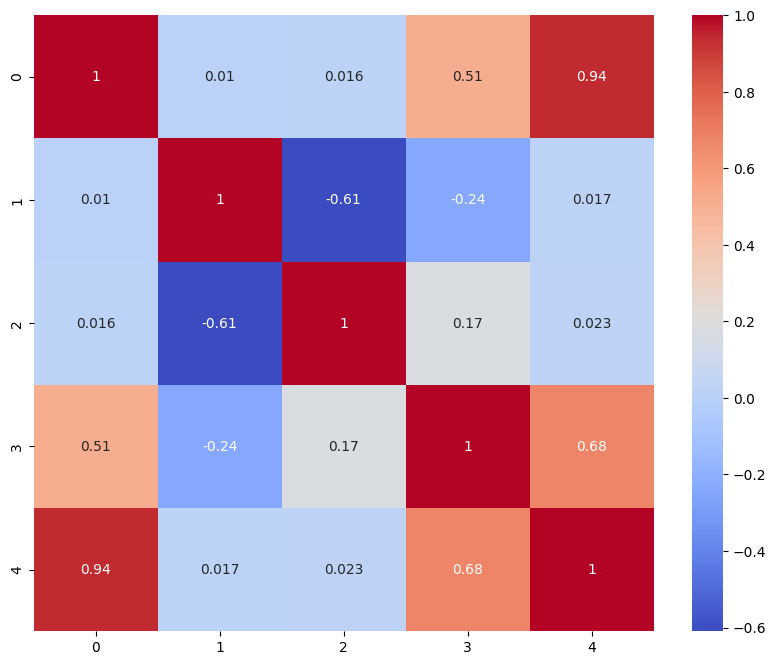

In [22]:


correlation_matrix = pd.DataFrame(feature_array).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy

def compute_entropy(labels):

    value_counts = np.bincount(labels)
    prob = value_counts / len(labels)
    return entropy(prob, base=2)

def compute_conditional_entropy(features, labels):
    unique_values = np.unique(features)
    cond_entropy = 0

    for value in unique_values:
        subset_labels = labels[features == value]
        cond_entropy += (len(subset_labels) / len(features)) * compute_entropy(subset_labels)

    return cond_entropy

def information_gain(features, labels):
    unique_features = np.unique(features)
    feature_info_gain = np.zeros(features.shape[1])
    total_entropy = compute_entropy(labels)

    for feature_idx in range(features.shape[1]):
        feature_values = features[:, feature_idx]
        cond_entropy = compute_conditional_entropy(feature_values, labels)
        feature_info_gain[feature_idx] = total_entropy - cond_entropy

    return feature_info_gain
def prepare_features_for_information_gain(first_order_features, classes):
    features_list = []
    labels_list = []
    
    for cls in classes:
        cls_features = first_order_features[cls]
        df = pd.DataFrame(cls_features)
        
        features_list.append(df.values)
        labels_list.extend([cls] * len(cls_features))

    feature_array = np.vstack(features_list)
    label_encoder = LabelEncoder()
    label_array = label_encoder.fit_transform(labels_list)

    return feature_array, label_array, label_encoder

    
first_order_features = extract_first_order_features_from_dataset(dataset_dir, classes)
    
feature_array, label_array, label_encoder = prepare_features_for_information_gain(first_order_features, classes)
    
ig_scores = information_gain(feature_array, label_array)
    
    # Rank features by Information Gain
sorted_indices = np.argsort(ig_scores)[::-1]
print("Features ranked by Information Gain:")
for idx in sorted_indices:
    print(f"Feature {idx}: Information Gain = {ig_scores[idx]}")
top_k = 5
selected_features_2 = feature_array[:, sorted_indices[:top_k]]
print(f"Selected top-{top_k} features:")
print(selected_features)


Features ranked by Information Gain:
Feature 3: Information Gain = 1.8208706301938664
Feature 2: Information Gain = 1.8208706301938664
Feature 1: Information Gain = 1.8208706301938664
Feature 0: Information Gain = 1.8208706301938664
Selected top-5 features:
[[5.94988004e-01 3.39439378e-01 1.15232194e-01 9.72504747e-01
  2.80007290e+02]
 [2.55851227e-01 2.02884155e-02 4.18097010e-04 9.78396617e-01
  1.28927734e+02]
 [5.93979074e-01 7.26133005e-02 5.33495129e-03 9.60834869e-01
  4.65575672e+01]
 ...
 [4.07055340e-01 8.05688565e-02 6.51104735e-03 9.37174057e-01
  2.03876768e+02]
 [3.30931441e-01 4.42962021e-02 1.96887451e-03 9.17594793e-01
  9.93745350e+01]
 [2.88252839e-01 3.40054603e-02 1.16761979e-03 9.77880930e-01
  9.75702457e+01]]


In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

def train_svm_with_polynomial_kernel(features, labels, degree=3, test_size=0.2, random_state=42):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state
    )

    # Initialize and train the SVM classifier
    svm_model = SVC(kernel="poly", degree=degree, random_state=random_state)
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return svm_model, accuracy



    polynomial_degree = 3

svm_model, accuracy = train_svm_with_polynomial_kernel(
        selected_features_2, label_array, degree=polynomial_degree
    )

print(f"Trained SVM model with polynomial kernel (degree {polynomial_degree}) achieved an accuracy of {accuracy * 100:.2f}%.")


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        65
           3       0.33      1.00      0.50        51

    accuracy                           0.33       154
   macro avg       0.08      0.25      0.12       154
weighted avg       0.11      0.33      0.16       154

Accuracy: 33.12%
Trained SVM model with polynomial kernel (degree 3) achieved an accuracy of 33.12%.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Sceond approach

In [29]:
!pip install  mahotas 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.0 MB/s eta 0:00:0000:0100:01


In [48]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from mahotas.features import haralick, tas

dataset_dir = "/kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset"
classes = ["Chickenpox", "Measles", "Monkeypox", "Normal"]

image_paths = {cls: [os.path.join(dataset_dir, cls, img) for img in os.listdir(os.path.join(dataset_dir, cls))] for cls in classes}

image_data = {}
for cls in classes:
    image_data[cls] = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths[cls]]

def extract_glcm_features(image):
    if image is None:  
        return {}
    distances = [1, 2, 3]
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    features = {}
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        for i, distance in enumerate(distances):
            for j, angle in enumerate(angles):
                features[f'GLCM_{prop}_d{distance}_a{j}'] = graycoprops(glcm, prop)[i, j]
    return features

def extract_glrlm_features(image):
    if image is None:
        return {}
    features = tas(image)
    glrlm_features = {f'GLRLM_{i}': val for i, val in enumerate(features)}
    return glrlm_features

def extract_glszm_features(image):
    if image is None:
        return {}
    features = haralick(image)
    glszm_features = {f'GLSZM_{i}': val for i, val in enumerate(features.mean(axis=0))}
    return glszm_features
data = []
for cls in classes:
    for image in image_data[cls]:
        glcm_features = extract_glcm_features(image)
        glrlm_features = extract_glrlm_features(image)
        glszm_features = extract_glszm_features(image)

        # Merge features
        all_features = {**glcm_features, **glrlm_features, **glszm_features}
        all_features['class'] = cls  # Add class label
        data.append(all_features)

df = pd.DataFrame(data)
print(df.head())
print(df.shape)

   GLCM_contrast_d1_a0  GLCM_contrast_d1_a1  GLCM_contrast_d1_a2  \
0           228.622317           260.902331            87.001361   
1            91.550609           136.797603            43.409033   
2            47.146100            50.955036             2.573751   
3           165.309157           247.155282            93.103519   
4           100.703395           122.079692            52.558656   

   GLCM_contrast_d1_a3  GLCM_contrast_d2_a0  GLCM_contrast_d2_a1  \
0           293.122323           563.736044           260.902331   
1           106.774196           269.053411           136.797603   
2            46.113294           120.286720            50.955036   
3           217.569386           474.092463           247.155282   
4           147.203624           290.865971           122.079692   

   GLCM_contrast_d2_a2  GLCM_contrast_d2_a3  GLCM_contrast_d3_a0  \
0           252.649292           293.122323           907.521594   
1           140.265223           106.774196   

In [52]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Encode the class labels
le = LabelEncoder()
df['class_encoded'] = le.fit_transform(df['class'])

# Separate features and target
X = df.drop(columns=['class', 'class_encoded'])
y = df['class_encoded']

# Apply Fisher's Score (using SelectKBest with mutual_info_classif as an approximation)
selector = SelectKBest(score_func=mutual_info_classif, k=10)
selector.fit(X, y)

# Get the top 10 features based on Fisher's Score
top_features = X.columns[selector.get_support()]

# Print the selected top 10 features
print("Top 10 features selected by Fisher's Score:")
print(top_features)

# Create a new DataFrame with the top 10 features and their corresponding class labels
top_features_df = df[list(top_features) + ['class']]
print(top_features_df.head())


Top 10 features selected by Fisher's Score:
Index(['GLCM_homogeneity_d2_a2', 'GLCM_homogeneity_d3_a2',
       'GLCM_homogeneity_d3_a3', 'GLCM_energy_d1_a1', 'GLCM_energy_d1_a2',
       'GLCM_energy_d2_a1', 'GLCM_ASM_d1_a0', 'GLCM_ASM_d1_a2',
       'GLCM_ASM_d2_a1', 'GLSZM_0'],
      dtype='object')
   GLCM_homogeneity_d2_a2  GLCM_homogeneity_d3_a2  GLCM_homogeneity_d3_a3  \
0                0.604766                0.570796                0.528797   
1                0.249829                0.191275                0.165720   
2                0.641283                0.565420                0.455406   
3                0.229882                0.188691                0.139287   
4                0.241635                0.186754                0.154102   

   GLCM_energy_d1_a1  GLCM_energy_d1_a2  GLCM_energy_d2_a1  GLCM_ASM_d1_a0  \
0           0.338437           0.346170           0.338437        0.116209   
1           0.019011           0.025839           0.019011        0.000472   
2 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Separate features and target
X = top_features_df.drop(columns=['class'])
y = top_features_df['class']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Separate features and target
X = top_features_df.drop(columns=['class'])
y = top_features_df['class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Initialize SMOTE and apply it to the training set
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_encoded)


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize models
models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate models
for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    # Train the model
    model.fit(X_resampled, y_resampled)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Decode predicted labels back to original format for report
    y_pred_decoded = le.inverse_transform(y_pred)
    y_test_decoded = y_test.to_numpy()  # Ensure it's in the same format as the predictions
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Display classification report
    report = classification_report(y_test_decoded, y_pred_decoded)
    print("Classification Report:")
    print(report)


--- SVM ---
Accuracy: 0.5065
Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.17      0.38      0.24        21
     Measles       0.71      0.28      0.40        18
   Monkeypox       0.59      0.57      0.58        56
      Normal       0.70      0.56      0.62        59

    accuracy                           0.51       154
   macro avg       0.55      0.45      0.46       154
weighted avg       0.59      0.51      0.53       154


--- Random Forest ---
Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.22      0.33      0.26        21
     Measles       0.29      0.33      0.31        18
   Monkeypox       0.58      0.52      0.55        56
      Normal       0.69      0.59      0.64        59

    accuracy                           0.50       154
   macro avg       0.44      0.44      0.44       154
weighted avg       0.54      0.50      0.51       154


--- Logistic 

In [58]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from mahotas.features import haralick, tas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Create DataFrame
df = pd.DataFrame(data)

# Separate features (X) and target (y)
X = df.drop('class', axis=1)
y = df['class']

# Handle potential missing values (NaNs) after feature extraction
X.fillna(0, inplace=True)  # Replace NaNs with 0. Consider other strategies if appropriate

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y) #stratify to keep class proportions

# Apply RFE with Logistic Regression
estimator = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='auto') # Increased max_iter
n_features_to_select = 20 
rfe = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Create new DataFrames with only selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train a Logistic Regression model on the selected features
model = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='auto')
model.fit(X_train_selected, y_train)

# Evaluate the model
accuracy = model.score(X_test_selected, y_test)
print("Accuracy on test set with selected features:", accuracy)

# Optionally, you can get the ranking of all features
feature_ranking = rfe.ranking_
feature_rank_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_ranking})
feature_rank_df = feature_rank_df.sort_values(by='Ranking')
print("\nFeature Ranking:\n", feature_rank_df)

Selected Features: Index(['GLCM_dissimilarity_d2_a3', 'GLCM_homogeneity_d1_a0',
       'GLCM_homogeneity_d1_a2', 'GLCM_homogeneity_d2_a0',
       'GLCM_homogeneity_d2_a2', 'GLCM_homogeneity_d3_a1',
       'GLCM_homogeneity_d3_a2', 'GLCM_correlation_d1_a2',
       'GLCM_correlation_d3_a2', 'GLRLM_38', 'GLRLM_40', 'GLRLM_41',
       'GLRLM_46', 'GLRLM_47', 'GLRLM_49', 'GLRLM_50', 'GLRLM_51', 'GLRLM_53',
       'GLSZM_8', 'GLSZM_10'],
      dtype='object')
Accuracy on test set with selected features: 0.7467532467532467

Feature Ranking:
                     Feature  Ranking
50   GLCM_correlation_d1_a2        1
24   GLCM_homogeneity_d1_a0        1
28   GLCM_homogeneity_d2_a0        1
110                GLRLM_38        1
30   GLCM_homogeneity_d2_a2        1
..                      ...      ...
64           GLCM_ASM_d2_a0      116
117                GLRLM_45      117
36        GLCM_energy_d1_a0      118
99                 GLRLM_27      119
127                 GLSZM_1      120

[139 rows x 2 

In [41]:
import os
import cv2
import pandas as pd
import numpy as np
image_paths = {cls: [os.path.join(dataset_dir, cls, img) for img in os.listdir(os.path.join(dataset_dir, cls))] for cls in classes}

sift = cv2.SIFT_create()

features = []
labels = []

for cls in classes:
    for img_path in image_paths[cls]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
          print(f"Error reading image: {img_path}")
          continue
        keypoints, descriptors = sift.detectAndCompute(img, None)

        if descriptors is not None:  
            for descriptor in descriptors:
                features.append(descriptor)
                labels.append(cls)
        else:
            print(f"No keypoints/descriptors found for image: {img_path}")

features = np.array(features)
labels = np.array(labels)

df = pd.DataFrame(features)
df['label'] = labels

print(df.head())
print(df['label'].value_counts())
print(f"Shape of the features dataframe: {df.shape}")

No keypoints/descriptors found for image: /kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset/Normal/normal166.png
No keypoints/descriptors found for image: /kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset/Normal/normal107.png
No keypoints/descriptors found for image: /kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset/Normal/normal239.png
      0    1    2    3      4    5    6    7      8    9  ...   119    120  \
0  33.0  4.0  1.0  0.0    0.0  0.0  0.0  2.0  181.0  3.0  ...   0.0    1.0   
1  18.0  7.0  1.0  1.0    1.0  0.0  0.0  0.0  131.0  5.0  ...  16.0   41.0   
2  37.0  0.0  0.0  0.0   31.0  3.0  0.0  7.0  164.0  1.0  ...  39.0   50.0   
3   7.0  5.0  1.0  8.0  140.0  1.0  0.0  0.0   53.0  7.0  ...  65.0   14.0   
4  11.0  4.0  1.0  3.0    9.0  0.0  0.0  0.0   93.0  2.0  ...   1.0  126.0   

    121   122   123  124  125  126   127       label  
0   0.0   0.0   1.0  4.0  0.0  0.0   0.0  Chickenpox  
1   1.0   0.0   0.0  1.0 

In [60]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

features = np.array(features)
labels = np.array(labels)
df = pd.DataFrame(features)
df['label'] = labels

X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify to keep the same proportion of classes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) #only transform the test set
logistic_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs') #increased max_iter
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)
def predict_image(image_path, model, scaler):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return "Error reading image"
    keypoints, descriptors = sift.detectAndCompute(img, None)
    if descriptors is None:
        return "No keypoints/descriptors found"
    
    scaled_descriptors = scaler.transform(descriptors)
    prediction = model.predict(scaled_descriptors)
    from collections import Counter
    most_common_prediction = Counter(prediction).most_common(1)[0][0]
    return most_common_prediction


test_image_path = "/kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset/Normal/normal1.png" # Replace with a valid path
prediction_result = predict_image(test_image_path, logistic_model, scaler)
print(f"Prediction for {test_image_path}: {prediction_result}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5375070768069448
Classification Report:
               precision    recall  f1-score   support

  Chickenpox       0.53      0.11      0.18      1991
     Measles       0.00      0.00      0.00      2141
   Monkeypox       0.56      0.78      0.66     10279
      Normal       0.48      0.46      0.47      6785

    accuracy                           0.54     21196
   macro avg       0.39      0.34      0.33     21196
weighted avg       0.48      0.54      0.49     21196

Prediction for /kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset/Normal/normal1.png: Normal


## Third approach

In [5]:
os.chdir('/kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset')

In [6]:
classes = ["Chickenpox", "Measles", "Monkeypox", "Normal"]
data = {cls: [os.path.join( cls, img) for img in os.listdir(os.path.join( cls))] for cls in classes}
images = {}
for i in data:
   images[i] = list(map(lambda x : (cv2.imread(x ) / 255)[..., ::-1]  ,data[i]))

In [7]:
def augment_image(image):
    augmenter = iaa.Sequential([
        iaa.Fliplr(0.5),  # Horizontal flip with 50% probability
        iaa.Flipud(0.5),  # Vertical flip with 50% probability
        iaa.Affine(rotate=(-30, 30)),  # Random rotation between -30 and 30 degrees
        iaa.Multiply((0.8, 1.2)),  # Adjust brightness
        iaa.GaussianBlur(sigma=(0, 1.0))  # Apply Gaussian blur
    ])
    return augmenter(image=image)

# Balance the dataset with augmentation
def balance_dataset(dataset):
    class_counts = {label: len(images) for label, images in dataset.items()}
    max_count = max(class_counts.values())

    balanced_dataset = {}
    for label, images in dataset.items():
        augmented_images = images[:]
        while len(augmented_images) < max_count:
            for img_path in images:
                new = img_path.split('/')[1]
                new = new.split('.')[0]
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                augmented_img = augment_image(img)
                augmented_img_path = f"/kaggle/working/{new}.jpg"
                cv2.imwrite(augmented_img_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))
                augmented_images.append(augmented_img_path)
                if len(augmented_images) >= max_count:
                    break
        balanced_dataset[label] = augmented_images
    return balanced_dataset

In [8]:


def wavelet_transform(image, wavelet='haar'):
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH

def hierarchical_wavelet_transform(image, wavelet='haar', levels=2):
    hierarchy = {}
    for channel_idx in range(image.shape[-1]):  # Process each channel independently
        channel_hierarchy = []
        current_image = image[..., channel_idx]

        for level in range(levels):
            LL, LH, HL, HH = wavelet_transform(current_image, wavelet)
            channel_hierarchy.append((LL, LH, HL, HH))  # Store sub-bands for each level
            current_image = LL  # Use the LL band for the next level decomposition

        hierarchy[f'Channel_{channel_idx}'] = channel_hierarchy
    return hierarchy


def extract_glcm_features(image):

    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    
    glcm = graycomatrix(normalized_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean()
    }
    return features

# Process Hierarchical Wavelet Coefficients
def process_wavelet_hierarchy(hierarchy):
    features = {}
    for channel, levels in hierarchy.items():
        for level, (LL, LH, HL, HH) in enumerate(levels):
            features[f'{channel}_Level_{level}_LL'] = extract_glcm_features(LL)
            features[f'{channel}_Level_{level}_LH'] = extract_glcm_features(LH)
            features[f'{channel}_Level_{level}_HL'] = extract_glcm_features(HL)
            features[f'{channel}_Level_{level}_HH'] = extract_glcm_features(HH)
    return features

# Extract features and add to DataFrame
def extract_features_to_dataframe(dataset, wavelet='haar', levels=2):
    data = []

    for label, images in dataset.items():
        for img_path in images:

            img = cv2.imread(img_path) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


            wavelet_hierarchy = hierarchical_wavelet_transform(img, wavelet=wavelet, levels=levels)


            features = process_wavelet_hierarchy(wavelet_hierarchy)

            flattened_features = {}
            for key, value in features.items():
                for sub_key, sub_value in value.items():
                    flattened_features[f'{key}_{sub_key}'] = sub_value


            flattened_features['label'] = label
            data.append(flattened_features)


    df = pd.DataFrame(data)
    return df

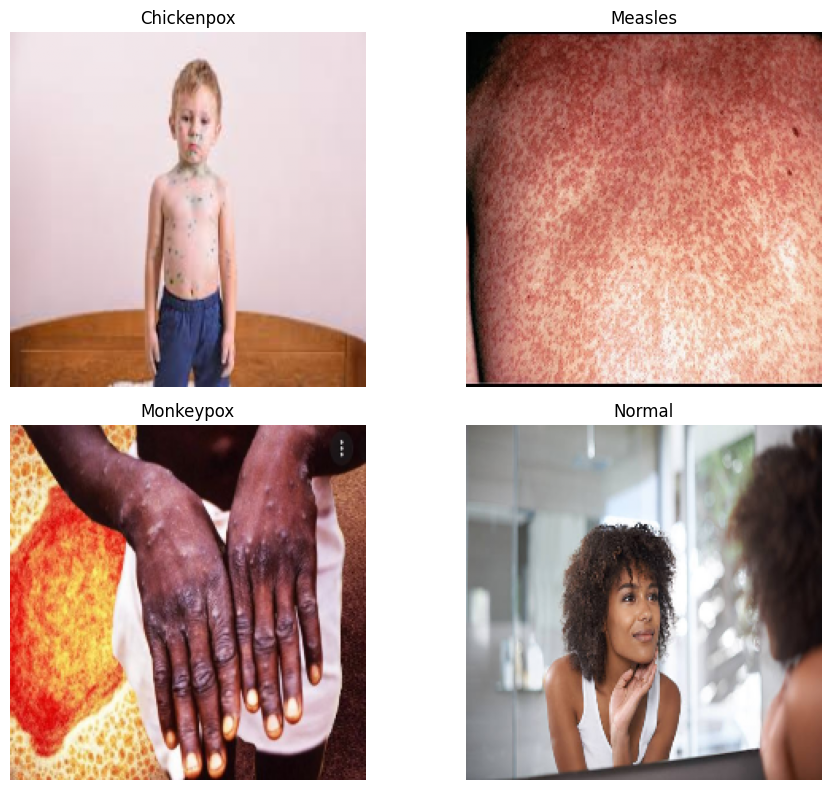

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))


classes = ["Chickenpox", "Measles", "Monkeypox", "Normal"]

for idx, class_name in enumerate(classes):

    random_image = random.choice(images[class_name])
    

    row = idx // 2
    col = idx % 2
    

    axs[row, col].imshow(random_image, cmap='gray')  # Display the image
    axs[row, col].set_title(f'{class_name}')
    axs[row, col].axis('off')  # Hide axes

plt.tight_layout()


plt.show()

In [9]:
balanced_dataset = balance_dataset(data)


In [ ]:
df = extract_features_to_dataframe(balanced_dataset, wavelet='haar', levels=2)

In [13]:
df = pd.read_csv('/kaggle/input/dataaaaaaa/features_aug.csv')

In [18]:
df.to_csv('/kaggle/working/features_aug.csv', index=False)

In [19]:
def fisher_feature_selection(X, y, k=10):

    F_values, _ = f_classif(X, y)


    top_k_indices = np.argsort(F_values)[-k:]


    X_selected = X[:, top_k_indices]

    return X_selected, top_k_indices

In [25]:
X = df.iloc[:, :-1].values  # All columns except the last one
y = df['label'].values


X_selected, selected_indices = fisher_feature_selection(X, y, k=30)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)


In [27]:


    # Create a pipeline with scaling, polynomial features (degree 3), and logistic regression
model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2)),
        ("logistic", LogisticRegression(max_iter=10000, solver='sag', multi_class='multinomial'))
    ])

    # Train the model
model.fit(X_train, y_train)

    # Predict on test data
y_pred = model.predict(X_test)

    # Evaluate the model
print("Selected Features Indices:", selected_indices)
print("Accuracy:", accuracy_score(y_test, y_pred))


Selected Features Indices: [10 46 74 42 14  3  6 38 70 27 59 91 23 71  7 55 39 87 11 75 43 30 94 62
 79 47 15 31 95 63]
Accuracy: 0.7073863636363636


In [28]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[55  8 14 11]
 [ 8 63 12  6]
 [15  4 73  3]
 [ 6  5 11 58]]


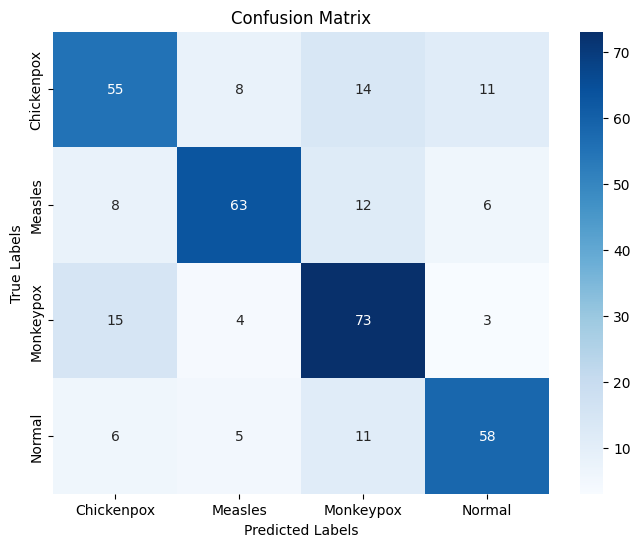

In [29]:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()